##1. Cargar librerias

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re
import json
import random
from wordcloud import WordCloud
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from pylab import savefig
import seaborn as sns
from random import sample
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.metrics.scores import (precision, recall)
from nltk.metrics import ConfusionMatrix
# Configuración warnings
# ==============================================================================
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus.reader import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
random.seed(1388)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##2.Cargar Datos

In [ ]:
df = pd.read_csv('train.csv', sep=',')
df['tipo']='train'

In [ ]:
c3=len(df[df['name']=='Petro'])
c2=len(df[df['name']=='Lopez'])
c1=len(df[df['name']=='Uribe'])

a=df[df['name']=='Petro']
msk = np.random.rand(len(a)) < ((c1-c3)/c3)
cat1= a[msk]


a=df[df['name']=='Lopez']
msk = np.random.rand(len(a)) < ((c1-c2)/c2)
cat2= a[msk]

df=pd.concat([df, cat1,cat2])

In [ ]:
df2 = pd.read_csv('test.csv', sep=',')
df2['name']='test'
df2['tipo']='test2'
df=pd.concat([df, df2])
df=df.reset_index()

In [ ]:
def obtenNGramas(listaPalabras, n):
    listaPalabras=listaPalabras.split()
    ngramas = []
    ff=''
    for i in range(len(listaPalabras)-(n-1)):
        ngramas.append(listaPalabras[i:i+n])
        f=''.join(map(str,listaPalabras[i:i+n]))
        ff = ff+' '+f
    return ff

In [ ]:
stop_words = set(stopwords.words('spanish'))
def text_preproc(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  return x

In [ ]:
df['text'] =  df['text'].apply(text_preproc)

In [ ]:
w=0
for i in df['text']:
        df['text'].iloc[w]=df['text'].iloc[w] + ' ' + obtenNGramas(i,2)
        w=w+1

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##2.1 Tokenizador especifico de datos

In [ ]:
import html
from typing import List

import regex  # https://github.com/nltk/nltk/issues/2409

from nltk.tokenize.api import TokenizerI


EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      </?3                       # heart
    )"""


URLS = r"""			# Capture 1: entire matched URL
  (?:
  https?:				# URL protocol and colon
    (?:
      /{1,3}				# 1-3 slashes
      |					#   or
      [a-z0-9%]				# Single letter or digit or '%'
                                       # (Trying not to match e.g. "URI::Escape")
    )
    |					#   or
                                       # looks like domain name followed by a slash:
    [a-z0-9.\-]+[.]
    (?:[a-z]{2,13})
    /
  )
  (?:					# One or more:
    [^\s()<>{}\[\]]+			# Run of non-space, non-()<>{}[]
    |					#   or
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\) # balanced parens, one level deep: (...(...)...)
    |
    \([^\s]+?\)				# balanced parens, non-recursive: (...)
  )+
  (?:					# End with:
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\) # balanced parens, one level deep: (...(...)...)
    |
    \([^\s]+?\)				# balanced parens, non-recursive: (...)
    |					#   or
    [^\s`!()\[\]{};:'".,<>?«»“”‘’]	# not a space or one of these punct chars
  )
  |					# OR, the following to match naked domains:
  (?:
  	(?<!@)			        # not preceded by a @, avoid matching foo@_gmail.com_
    [a-z0-9]+
    (?:[.\-][a-z0-9]+)*
    [.]
    (?:[a-z]{2,13})
    \b
    /?
    (?!@)			        # not succeeded by a @,
                            # avoid matching "foo.na" in "foo.na@example.com"
  )
"""

# Regex for recognizing phone numbers:
PHONE_REGEX = r"""
    (?:
      (?:            # (international)
        \+?[01]
        [ *\-.\)]*
      )?
      (?:            # (area code)
        [\(]?
        \d{3}
        [ *\-.\)]*
      )?
      \d{3}          # exchange
      [ *\-.\)]*
      \d{4}          # base
    )"""

# The components of the tokenizer:
REGEXPS = (
    URLS,
    # ASCII Emoticons
    EMOTICONS,
    # HTML tags:
    r"""<[^>\s]+>""",
    # ASCII Arrows
    r"""[\-]+>|<[\-]+""",
    # Twitter username:
    r"""(?:@[\w_]+)""",
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",
    # email addresses
    r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]""",
    # Zero-Width-Joiner and Skin tone modifier emojis
    """.(?:
        [\U0001F3FB-\U0001F3FF]?(?:\u200d.[\U0001F3FB-\U0001F3FF]?)+
        |
        [\U0001F3FB-\U0001F3FF]
    )""",
    # Remaining word types:
    r"""
    (?:[^\W\d_](?:[^\W\d_]|['\-_])+[^\W\d_]) # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """,
)

# Take the main components and add a phone regex as the second parameter
REGEXPS_PHONE = (REGEXPS[0], PHONE_REGEX, *REGEXPS[1:])

######################################################################
# TweetTokenizer.WORD_RE and TweetTokenizer.PHONE_WORD_RE represent
# the core tokenizing regexes. They are compiled lazily.

# WORD_RE performs poorly on these patterns:
HANG_RE = regex.compile(r"([^a-zA-Z0-9])\1{3,}")

# The emoticon string gets its own regex so that we can preserve case for
# them as needed:
EMOTICON_RE = regex.compile(EMOTICONS, regex.VERBOSE | regex.I | regex.UNICODE)

# These are for regularizing HTML entities to Unicode:
ENT_RE = regex.compile(r"&(#?(x?))([^&;\s]+);")

# For stripping away handles from a tweet:
HANDLES_RE = regex.compile(
    r"(?<![A-Za-z0-9_!@#\$%&*])@"
    r"(([A-Za-z0-9_]){15}(?!@)|([A-Za-z0-9_]){1,14}(?![A-Za-z0-9_]*@))"
)

def _str_to_unicode(text, encoding=None, errors="strict"):
    if encoding is None:
        encoding = "utf-8"
    if isinstance(text, bytes):
        return text.decode(encoding, errors)
    return text


def _replace_html_entities(text, keep=(), remove_illegal=True, encoding="utf-8"):
    """
    Remove entities from text by converting them to their
    corresponding unicode character.

    :param text: a unicode string or a byte string encoded in the given
    `encoding` (which defaults to 'utf-8').

    :param list keep:  list of entity names which should not be replaced.\
    This supports both numeric entities (``&#nnnn;`` and ``&#hhhh;``)
    and named entities (such as ``&nbsp;`` or ``&gt;``).

    :param bool remove_illegal: If `True`, entities that can't be converted are\
    removed. Otherwise, entities that can't be converted are kept "as
    is".

    :returns: A unicode string with the entities removed.

    See https://github.com/scrapy/w3lib/blob/master/w3lib/html.py

        >>> from nltk.tokenize.casual import _replace_html_entities
        >>> _replace_html_entities(b'Price: &pound;100')
        'Price: \\xa3100'
        >>> print(_replace_html_entities(b'Price: &pound;100'))
        Price: £100
        >>>
    """

    def _convert_entity(match):
        entity_body = match.group(3)
        if match.group(1):
            try:
                if match.group(2):
                    number = int(entity_body, 16)
                else:
                    number = int(entity_body, 10)
                # Numeric character references in the 80-9F range are typically
                # interpreted by browsers as representing the characters mapped
                # to bytes 80-9F in the Windows-1252 encoding. For more info
                # see: https://en.wikipedia.org/wiki/ISO/IEC_8859-1#Similar_character_sets
                if 0x80 <= number <= 0x9F:
                    return bytes((number,)).decode("cp1252")
            except ValueError:
                number = None
        else:
            if entity_body in keep:
                return match.group(0)
            number = html.entities.name2codepoint.get(entity_body)
        if number is not None:
            try:
                return chr(number)
            except (ValueError, OverflowError):
                pass

        return "" if remove_illegal else match.group(0)

    return ENT_RE.sub(_convert_entity, _str_to_unicode(text, encoding))


######################################################################


class TweetTokenizer(TokenizerI):
    r"""
    Tokenizer for tweets.

        >>> from nltk.tokenize import TweetTokenizer
        >>> tknzr = TweetTokenizer()
        >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
        >>> tknzr.tokenize(s0) # doctest: +NORMALIZE_WHITESPACE
        ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->',
         '<--']

    Examples using `strip_handles` and `reduce_len parameters`:

        >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
        >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
        >>> tknzr.tokenize(s1)
        [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
    """

    # Values used to lazily compile WORD_RE and PHONE_WORD_RE,
    # which are the core tokenizing regexes.
    _WORD_RE = None
    _PHONE_WORD_RE = None

    ######################################################################

    def __init__(
        self,
        preserve_case=True,
        reduce_len=False,
        strip_handles=False,
        match_phone_numbers=True,
    ):
        """
        Create a `TweetTokenizer` instance with settings for use in the `tokenize` method.

        :param preserve_case: Flag indicating whether to preserve the casing (capitalisation)
            of text used in the `tokenize` method. Defaults to True.
        :type preserve_case: bool
        :param reduce_len: Flag indicating whether to replace repeated character sequences
            of length 3 or greater with sequences of length 3. Defaults to False.
        :type reduce_len: bool
        :param strip_handles: Flag indicating whether to remove Twitter handles of text used
            in the `tokenize` method. Defaults to False.
        :type strip_handles: bool
        :param match_phone_numbers: Flag indicating whether the `tokenize` method should look
            for phone numbers. Defaults to True.
        :type match_phone_numbers: bool
        """
        self.preserve_case = preserve_case
        self.reduce_len = reduce_len
        self.strip_handles = strip_handles
        self.match_phone_numbers = match_phone_numbers


    def tokenize(self, text: str) -> List[str]:
        """Tokenize the input text.

        :param text: str
        :rtype: list(str)
        :return: a tokenized list of strings; joining this list returns\
        the original string if `preserve_case=False`.
        """
        # Fix HTML character entities:
        text = _replace_html_entities(text)
        # Remove username handles
        if self.strip_handles:
            text = remove_handles(text)
        # Normalize word lengthening
        if self.reduce_len:
            text = reduce_lengthening(text)
        # Shorten problematic sequences of characters
        safe_text = HANG_RE.sub(r"\1\1\1", text)
        # Recognise phone numbers during tokenization
        if self.match_phone_numbers:
            words = self.PHONE_WORD_RE.findall(safe_text)
        else:
            words = self.WORD_RE.findall(safe_text)
        # Possibly alter the case, but avoid changing emoticons like :D into :d:
        if not self.preserve_case:
            words = list(
                map((lambda x: x if EMOTICON_RE.search(x) else x.lower()), words)
            )
        return words


    @property
    def WORD_RE(self) -> "regex.Pattern":
        """Core TweetTokenizer regex"""
        # Compiles the regex for this and all future instantiations of TweetTokenizer.
        if not type(self)._WORD_RE:
            type(self)._WORD_RE = regex.compile(
                f"({'|'.join(REGEXPS)})",
                regex.VERBOSE | regex.I | regex.UNICODE,
            )
        return type(self)._WORD_RE

    @property
    def PHONE_WORD_RE(self) -> "regex.Pattern":
        """Secondary core TweetTokenizer regex"""
        # Compiles the regex for this and all future instantiations of TweetTokenizer.
        if not type(self)._PHONE_WORD_RE:
            type(self)._PHONE_WORD_RE = regex.compile(
                f"({'|'.join(REGEXPS_PHONE)})",
                regex.VERBOSE | regex.I | regex.UNICODE,
            )
        return type(self)._PHONE_WORD_RE




######################################################################
# Normalization Functions
######################################################################


def reduce_lengthening(text):
    """
    Replace repeated character sequences of length 3 or greater with sequences
    of length 3.
    """
    pattern = regex.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1\1", text)



def remove_handles(text):
    """
    Remove Twitter username handles from text.
    """
    # Substitute handles with ' ' to ensure that text on either side of removed handles are tokenized correctly
    return HANDLES_RE.sub(" ", text)



######################################################################
# Tokenization Function
######################################################################


def casual_tokenize(
    text,
    preserve_case=True,
    reduce_len=False,
    strip_handles=False,
    match_phone_numbers=True,
):
    """
    Convenience function for wrapping the tokenizer.
    """
    return TweetTokenizer(
        preserve_case=preserve_case,
        reduce_len=reduce_len,
        strip_handles=strip_handles,
        match_phone_numbers=match_phone_numbers,
    ).tokenize(text)



###############################################################################

##3. Limpieza de Datos

In [ ]:
stop_words = set(stopwords.words('spanish'))
stop_words.add('rt') 
ps = PorterStemmer()
count = 0
docs_token_clean = []
vocabulary_tokenz = []
vocabulary_tokenz_Petro = []
vocabulary_tokenz_Uribe = []
vocabulary_tokenz_Lopez = []
a,b = 'áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN'
trans = str.maketrans(a,b)
for doc in df['text']:  
  count += 1
  # Tokenizar
  #tokens_doc = word_tokenize(doc)  
  tokens_doc = casual_tokenize(doc) 
  # Minusculas
  tokens_doc = [w.lower() for w in tokens_doc]
  # Quitar tildes
  tokens_doc = [w.translate(trans) for w in  tokens_doc]
  # Quitar puntuacion
  tokens_doc_wo_stop = [w for w in tokens_doc if w.isalpha()]
  #tokens_doc_wo_stop = tokens_doc
  # Quitar stopwords
  tokens_doc_wo_stop = [w for w in tokens_doc_wo_stop if not w.lower() in stop_words]
  # Stemizar
  #tokens_docs_stem = [ps.stem(w) for w in tokens_doc_wo_stop]
  tokens_docs_stem=tokens_doc_wo_stop
  # Tokens definitivos
  docs_token_clean.append({'index': (count), 'text': tokens_docs_stem})
  if df.iloc[count-1,2] == 'Petro': 
    vocabulary_tokenz_Petro += tokens_docs_stem
  if df.iloc[count-1,2] == 'Uribe': 
    vocabulary_tokenz_Uribe += tokens_docs_stem
  if df.iloc[count-1,2] == 'Lopez': 
    vocabulary_tokenz_Lopez += tokens_docs_stem
  vocabulary_tokenz += tokens_docs_stem
#docs_token_clean

##4. Enendimiento de datos

4.1. Petro

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(-0.5, 399.5, 199.5, -0.5)

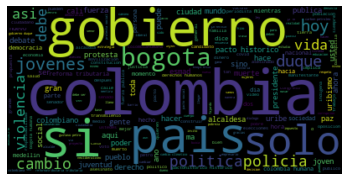

In [ ]:
wordcloud = WordCloud().generate(' '.join(vocabulary_tokenz_Petro))
%pylab inline
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

4.2. Uribe

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

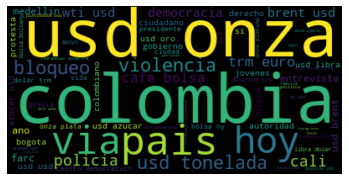

In [ ]:
wordcloud = WordCloud().generate(' '.join(vocabulary_tokenz_Uribe))
%pylab inline
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

4.3. Lopez

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

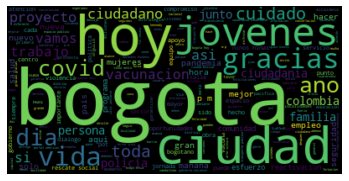

In [ ]:
wordcloud = WordCloud().generate(' '.join(vocabulary_tokenz_Lopez))
%pylab inline
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

##5. Modelamiento

In [ ]:
df_tokens = pd.DataFrame(docs_token_clean)
df_tokens_final= pd.concat([df_tokens['text'], df['name']], axis=1, join='inner')
#display(df_tokens_final)

In [ ]:
#Creación del set de datos input del modelo
text_string=[]
count=0
for doc in df_tokens_final['text']: 
  text_string.append((' '.join(doc),df_tokens_final.iloc[count,1]))
  count += 1
#text_string

In [ ]:
# Creacion de diccionaio del modelo
a=pd.value_counts(np.array(vocabulary_tokenz))
b=pd.DataFrame(a)
b=b.reset_index()
b.columns=['Words','freq']
Vocabulary_dic=set(b[b['freq']>100]['Words'])
#Vocabulary_dic

In [ ]:
featuresets = [({Word: (Word in word_tokenize(x[0])) for Word in Vocabulary_dic}, x[1]) for x in text_string]

In [ ]:
featuresets_train = pd.DataFrame(featuresets)
featuresets_train=featuresets_train[featuresets_train[1]!='test']
featuresets_train=featuresets_train.values.tolist()

featuresets_test = pd.DataFrame(featuresets)
featuresets_test=featuresets_test[featuresets_test[1]=='test']
featuresets_test=featuresets_test[0].values.tolist()



In [ ]:
#División del grupo test y train
data_model=featuresets_train
#random.shuffle(data_model)
train_set = data_model[:4400]
test_set = data_model[4400:]

#train_set, test_set = featuresets[100:], featuresets[:100]

In [ ]:
#Entrenamiento del modelo
classifier = nltk.NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features()

Most Informative Features
                   ninas = True            Lopez : Uribe  =     77.3 : 1.0
           oportunidades = True            Lopez : Uribe  =     64.2 : 1.0
            reactivacion = True            Lopez : Petro  =     58.2 : 1.0
              vacunacion = True            Lopez : Uribe  =     48.0 : 1.0
               historico = True            Petro : Uribe  =     44.8 : 1.0
              trabajando = True            Lopez : Petro  =     40.3 : 1.0
                    cafe = True            Uribe : Petro  =     33.0 : 1.0
                   metro = True            Lopez : Uribe  =     32.8 : 1.0
                    suba = True            Lopez : Uribe  =     32.8 : 1.0
               autoridad = True            Uribe : Petro  =     32.1 : 1.0


In [ ]:
print ('accuracy ',nltk.classify.accuracy(classifier, test_set) )

accuracy  0.6210526315789474


In [ ]:
predict_df = []
i=-1
for doc in featuresets_test: 
  i=i+1
  y_predicted = classifier.classify(featuresets_test[i])
  #predict_df.append({'index': (count), 'text': y_predicted}) 
  predict_df.append(y_predicted) 
#y_predicted = classifier.classify(featuresets_test[0])
#y_predicted
predict_df=pd.DataFrame(predict_df)
predict_df=pd.DataFrame(df2['id']).join(predict_df)
predict_df=predict_df.rename({0: 'name'}, axis=1)

In [ ]:
predict_df.to_csv('Econoinges3.csv', index=False)

In [ ]:
df['name'].to_csv('Econoinges22.csv', index=False)